In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import progressbar

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
train_terms = pd.read_csv("/kaggle/input/cafa-5-protein-function-prediction/Train/train_terms.tsv",sep="\t")
print(train_terms.shape)

(5363863, 3)


In [4]:
train_terms.head()

,EntryID,term,aspect
0,A0A009IHW8,GO:0008152,BPO
1,A0A009IHW8,GO:0034655,BPO
2,A0A009IHW8,GO:0072523,BPO
3,A0A009IHW8,GO:0044270,BPO
4,A0A009IHW8,GO:0006753,BPO


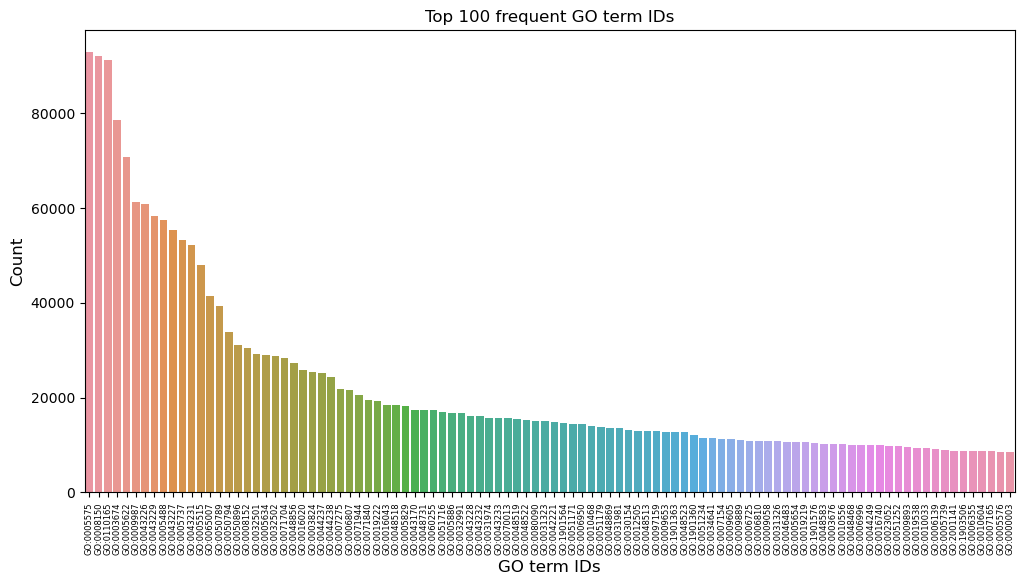

In [5]:
# Select first 1500 values for plotting
plot_df = train_terms['term'].value_counts().iloc[:100]

figure, axis = plt.subplots(1, 1, figsize=(12, 6))

bp = sns.barplot(ax=axis, x=np.array(plot_df.index), y=plot_df.values)
bp.set_xticklabels(bp.get_xticklabels(), rotation=90, size = 6)
axis.set_title('Top 100 frequent GO term IDs')
bp.set_xlabel("GO term IDs", fontsize = 12)
bp.set_ylabel("Count", fontsize = 12)
plt.show()

In [6]:
# Set the limit for label
num_of_labels = 1500

# Take value counts in descending order and fetch first 1500 `GO term ID` as labels
labels = train_terms['term'].value_counts().index[:num_of_labels].tolist()

In [7]:
# Fetch the train_terms data for the relevant labels only
train_terms_updated = train_terms.loc[train_terms['term'].isin(labels)]

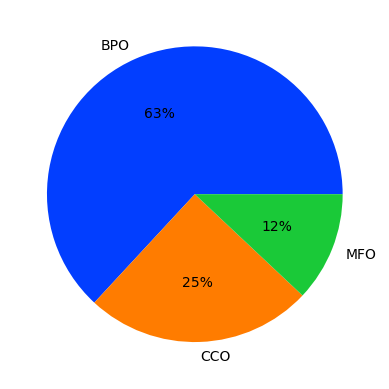

In [8]:
pie_df = train_terms_updated['aspect'].value_counts()
palette_color = sns.color_palette('bright')
plt.pie(pie_df.values, labels=np.array(pie_df.index), colors=palette_color, autopct='%.0f%%')
plt.show()

In [9]:
train_protein_ids = np.load('/kaggle/input/t5embeds/train_ids.npy')
print(train_protein_ids.shape)

(142246,)


In [10]:
train_embeddings = np.load('/kaggle/input/t5embeds/train_embeds.npy')

# Now lets convert embeddings numpy array(train_embeddings) into pandas dataframe.
column_num = train_embeddings.shape[1]
train_df = pd.DataFrame(train_embeddings, columns = ["Column_" + str(i) for i in range(1, column_num+1)])
print(train_df.shape)

(142246, 1024)


In [11]:
# Setup progressbar settings.
# This is strictly for aesthetic.
bar = progressbar.ProgressBar(maxval=num_of_labels, \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])

# Create an empty dataframe of required size for storing the labels,
# i.e, train_size x num_of_labels (142246 x 1500)
train_size = train_protein_ids.shape[0] # len(X)
train_labels = np.zeros((train_size ,num_of_labels))

# Convert from numpy to pandas series for better handling
series_train_protein_ids = pd.Series(train_protein_ids)

# Loop through each label
for i in range(num_of_labels):
    # For each label, fetch the corresponding train_terms data
    n_train_terms = train_terms_updated[train_terms_updated['term'] ==  labels[i]]
    
    # Fetch all the unique EntryId aka proteins related to the current label(GO term ID)
    label_related_proteins = n_train_terms['EntryID'].unique()
    
    # In the series_train_protein_ids pandas series, if a protein is related
    # to the current label, then mark it as 1, else 0.
    # Replace the ith column of train_Y with with that pandas series.
    train_labels[:,i] =  series_train_protein_ids.isin(label_related_proteins).astype(float)
    
    # Progress bar percentage increase
    bar.update(i+1)

# Notify the end of progress bar 
bar.finish()

# Convert train_Y numpy into pandas dataframe
labels_df = pd.DataFrame(data = train_labels, columns = labels)
print(labels_df.shape)

[========================================================================] 100%


(142246, 1500)


In [12]:
train_df.head()

,Column_1,Column_2,Column_3,Column_4,Column_5,Column_6,Column_7,Column_8,Column_9,Column_10,...,Column_1015,Column_1016,Column_1017,Column_1018,Column_1019,Column_1020,Column_1021,Column_1022,Column_1023,Column_1024
0,0.049488,-0.032935,0.032473,-0.033723,-0.059505,0.075936,-0.045860,-0.104476,-0.072112,0.038806,...,-0.046516,-0.028773,-0.021878,-0.097883,0.056475,0.080950,-0.020938,-0.043532,0.096463,0.073070
1,-0.044616,0.064925,-0.080263,-0.075338,-0.004731,0.025408,-0.024685,-0.016568,-0.038980,-0.033870,...,-0.040173,0.003925,0.006130,0.007362,-0.066848,0.106882,-0.030134,0.026724,0.027879,-0.048430
2,-0.020128,-0.049779,0.007894,-0.000829,-0.047737,0.086453,-0.038107,-0.036379,0.029611,0.045029,...,0.029388,0.008456,0.000697,0.013502,-0.005968,-0.011571,0.005704,-0.036103,0.007693,0.106234
3,-0.007515,0.060628,0.004045,0.027056,-0.021542,0.010380,-0.025064,-0.055834,0.068238,0.027764,...,0.020792,0.023307,0.009009,0.018211,0.020820,-0.031738,0.013279,-0.018357,0.008087,0.010917
4,0.013468,0.041516,0.018435,-0.035595,0.008770,0.018699,-0.015452,-0.038092,-0.038326,-0.012299,...,-0.044742,-0.025432,-0.060886,-0.026915,0.026342,0.017237,0.014731,-0.016861,-0.016272,0.037054


In [15]:
test_embeddings = np.load('/kaggle/input/t5embeds/test_embeds.npy')

column_num = test_embeddings.shape[1]
test_df = pd.DataFrame(test_embeddings, columns = ["Column_" + str(i) for i in range(1, column_num+1)])
print(test_df.shape)

(141865, 1024)


In [ ]:
knn_clf=KNeighborsClassifier()
knn_clf.fit(train_df,labels_df)

In [ ]:
def get_raw_outputs_with_verbose(classifier, X):
    n_samples = len(X)
    raw_outputs = []

    print("Getting raw outputs:")
    for i, x in enumerate(X):
        progress = (i + 1) / n_samples * 100
        print(f"\rProgress: {progress:.2f}%", end="")
        raw_output = classifier.predict_proba([x])[0]
        raw_outputs.append(raw_output)

    print("\nRaw outputs obtained.")
    return raw_outputs

In [ ]:
#predictions =  knn_clf.predict(test_df)
raw_outputs = get_raw_outputs_with_verbose(test_df)
raw_outputs.to_csv('prob_pred.csv')

In [ ]:
predictions = pd.read_csv('/kaggle/input/predictions/predictions.csv', on_bad_lines='skip')

In [3]:
ypred_num = predictions.shape[1]
ypred_df = pd.DataFrame(predictions, columns = ["Column_" + str(i) for i in range(1, ypred_num+1)])
print(ypred_df.shape)
#print(ypred_df)

(108143, 1500)


In [ ]:
ypred_df.to_csv('predictions.csv', index=False)

In [10]:
predictions.shape

(108143, 1500)

In [54]:
predictions_small = predictions.iloc[0:1000,0:10000]
predictions_small.shape

(1000, 1500)

In [5]:
test_protein_ids = np.load('/kaggle/input/t5embeds/test_ids.npy')
test_protein_ids

array(['Q9CQV8', 'P62259', 'P68510', ..., 'C0HK73', 'C0HK74',
       'A0A3G2FQK2'], dtype='<U10')

In [50]:
df_submission = pd.DataFrame(columns = ['Protein Id', 'GO Term Id','Prediction'])
df_submission

,Protein Id,GO Term Id,Prediction


In [55]:
predictions_small.shape[1]

1500

In [56]:
l = []
for k in list(test_protein_ids):
    l += [k] * predictions_small.shape[1]   

In [57]:
df_submission['Protein Id'] = l[0:10000]
df_submission.head()

,Protein Id,GO Term Id,Prediction
0,Q9CQV8,NaN,NaN
1,Q9CQV8,NaN,NaN
2,Q9CQV8,NaN,NaN
3,Q9CQV8,NaN,NaN
4,Q9CQV8,NaN,NaN


In [60]:
labels = labels[0:10000]
len(labels)

500

In [61]:
df_submission['GO Term Id'] = pd.Series(labels * predictions_small.shape[0])
df_submission.head()

,Protein Id,GO Term Id,Prediction
0,Q9CQV8,GO:0005575,NaN
1,Q9CQV8,GO:0008150,NaN
2,Q9CQV8,GO:0110165,NaN
3,Q9CQV8,GO:0003674,NaN
4,Q9CQV8,GO:0005622,NaN


In [62]:
predictions_small = np.array(predictions_small)

In [64]:
df_submission['Prediction'] = pd.Series(predictions_small.ravel())

In [66]:
df_submission = df_submission[0:10000]

In [67]:
df_submission

,Protein Id,GO Term Id,Prediction
0,Q9CQV8,GO:0005575,1.0
1,Q9CQV8,GO:0008150,1.0
2,Q9CQV8,GO:0110165,1.0
3,Q9CQV8,GO:0003674,1.0
4,Q9CQV8,GO:0005622,1.0
...,...,...,...
9995,P63101,GO:0044403,0.0
9996,P63101,GO:0042803,0.0
9997,P63101,GO:0016829,0.0
9998,P63101,GO:0090596,0.0


In [68]:
df_submission.to_csv("submission.tsv",header=False, index=False, sep="\t")
df_submission.head()

,Protein Id,GO Term Id,Prediction
0,Q9CQV8,GO:0005575,1.0
1,Q9CQV8,GO:0008150,1.0
2,Q9CQV8,GO:0110165,1.0
3,Q9CQV8,GO:0003674,1.0
4,Q9CQV8,GO:0005622,1.0


In [70]:
sub = pd.read_csv("/kaggle/working/submission.tsv",sep="\t", header = None)

sub.shape

(10000, 3)

In [34]:
df_submission.shape

(500, 3)

In [ ]:
# from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# result = confusion_matrix(y_test, ypred)
# print(“Confusion Matrix:”)
# print(result)
# result1 = classification_report(y_test, ypred)
# print(“Classification Report:”,)
# print (result1)
# result2 = accuracy_score(y_test,ypred)
# print(“Accuracy:”,result2)

In [38]:
# # Reference: https://www.kaggle.com/code/alexandervc/baseline-multilabel-to-multitarget-binary

# df_submission = pd.DataFrame(columns = ['Protein Id', 'GO Term Id','Prediction'])
# test_protein_ids = np.load('/kaggle/input/t5embeds/test_ids.npy')
l = []
for k in list(test_protein_ids):
    l += [ k] * predictions_small.shape[1]   

df_submission['Protein Id'] = l[0:500]
df_submission['GO Term Id'] = labels * predictions_small.shape[0]
df_submission['Prediction'] = predictions_small.ravel()
df_submission.to_csv("submission.tsv",header=False, index=False, sep="\t")

ValueError: Length of values (50000) does not match length of index (500)

In [30]:
df_submission

,Protein Id,GO Term Id,Prediction
0,Q9CQV8,GO:0005575,1.0
1,Q9CQV8,GO:0008150,1.0
2,Q9CQV8,GO:0110165,1.0
3,Q9CQV8,GO:0003674,1.0
4,Q9CQV8,GO:0005622,1.0
...,...,...,...
495,Q9CQV8,GO:0044403,0.0
496,Q9CQV8,GO:0042803,0.0
497,Q9CQV8,GO:0016829,0.0
498,Q9CQV8,GO:0090596,0.0
